## Analysis of Labels Versus Tracker Outputs

Feb 4

Very messy way of analyzing text files.

Heavy gpt use.

### 1. Setup

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
# Configure analysis

root = 'D:/bme/'
labels_dir = 'labels/coords_M19/'
logs_dir = 'logs/M19/'
temp_dir = 'labels/adj_19/'

ERR_THRESH = 50

In [4]:
def replace_in_file(file_path, out_file_path):
    """
    Searches for 'search_text' in the specified file and replaces it with 'new_text'.
    Writes the modified content back to the same file.
    
    Args:
        file_path (str): Path to the input text file.
        search_text (str): The text to search for.
        new_text (str): The replacement text.
    """
    with open(file_path, 'r') as file:
        filedata = file.read()
        modified_data = filedata.replace(' ', ',')

    with open(out_file_path, 'w') as file:
        file.write(modified_data)


In [5]:
# Intermediate
for filename in os.listdir(root + logs_dir):
    if filename.endswith(".bag"): 
        file_path = os.path.join(root + logs_dir, filename)
        replace_in_file(file_path, os.path.join(root + temp_dir, filename))

In [22]:
# Load coordinates into pandas

labels_df = pd.DataFrame()

for filename in os.listdir(root + labels_dir):
    if filename.endswith(".txt"): 
        file_path = os.path.join(root + labels_dir, filename)
        
        current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'x', 'y', 'd'])
        current_df['date'] = filename[6:-4]
        
        labels_df = labels_df.append(current_df, ignore_index=True)
labels_df['t'] = pd.to_numeric(labels_df['t'], errors='coerce')
labels_df['x'] = pd.to_numeric(labels_df['x'], errors='coerce')
labels_df['y'] = pd.to_numeric(labels_df['y'], errors='coerce')
labels_df['d'] = pd.to_numeric(labels_df['d'], errors='coerce')


logs_df = pd.DataFrame()
for filename in os.listdir(root + temp_dir):
    if filename.endswith(".bag"): 
        file_path = os.path.join(root + temp_dir, filename)
        
        current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'a', 'b', 'c', 'd', 'e', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10'])
        current_df['date'] = filename[8:-4]
        
        logs_df = logs_df.append(current_df, ignore_index=True)
logs_df['t'] = pd.to_numeric(logs_df['t'], errors='coerce')
#logs_df['x'] = pd.to_numeric(logs_df['x'], errors='coerce')
#logs_df['y'] = pd.to_numeric(logs_df['y'], errors='coerce')
#logs_df['d'] = pd.to_numeric(logs_df['d'], errors='coerce')

C:\Users\finno\AppData\Local\Temp\ipykernel_46800\1672521888.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_46800\1672521888.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_46800\1672521888.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_46800\1672521888.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_d

In [23]:
# Set '[' elements to empty

logs_df.replace('[', np.nan, inplace=True)
logs_df.replace(']', np.nan, inplace=True)

In [26]:
columns_to_align = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10']

# Function to process each row
def custom_shift(row):
    # Convert the row to a list for easier manipulation
    values = row[columns_to_align].tolist()
    new_values = [np.nan] * len(values)  # Initialize with empty values
    
    for i in range(len(values)):
        if not pd.isna(values[i]):  # If the value is not NaN, shift it to the leftmost available position
            for j in range(len(new_values)):
                if pd.isna(new_values[j]):  # Find the first available position
                    new_values[j] = values[i]  # Move the value to this position
                    break  # Move to the next value in the original row
                    
    return pd.Series(new_values, index=columns_to_align)

# Apply the transformation
logs_df[columns_to_align] = logs_df.apply(custom_shift, axis=1)


In [28]:
# Apply simple preprocessing
logs_pdf = logs_df[logs_df['date'] != '20231027_140520']
labels_pdf = labels_df[labels_df['date'] != '20231027_140520']
print(logs_df.shape)
print(logs_pdf.shape)

(5523, 17)
(5523, 17)


In [29]:
logs_pdf['b5'] = logs_pdf.b1.apply(lambda x: str(x)[1:] if ((str(x)[0]=='(') or (str(x)[0]=='[')) else x)
logs_pdf['b6'] = logs_pdf.b4.apply(lambda x: str(x)[:-1] if ((str(x)[-1]==']') or (str(x)[-1]==')')) else x)

In [30]:
logs_pdf = logs_pdf[logs_pdf.b==0]

In [31]:
logs_pdf['x'] = (logs_pdf.b5.astype(int) + logs_pdf.b3.astype(int))//2
logs_pdf['y'] = (logs_pdf.b2.astype(int) + logs_pdf.b6.astype(int))//2

In [32]:
logs_pdf['date'] = logs_pdf['date'].apply(lambda x: '2'+x)

### 2. Frequency

In [33]:
logs_pdf['t_diff'] = logs_pdf.groupby('date')['t'].diff() / 1000
logs_pdf['t_diff'].replace(0, np.nan, inplace=True)
logs_pdf['t_freq'] = 1 / logs_pdf['t_diff']
filt = logs_pdf[logs_pdf['t_freq'] < 20]

num = filt.groupby('date').count().t_freq
means = filt.groupby('date').mean().t_freq
stds = filt.groupby('date').std().t_freq

C:\Users\finno\AppData\Local\Temp\ipykernel_46800\1231459958.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = filt.groupby('date').mean().t_freq
C:\Users\finno\AppData\Local\Temp\ipykernel_46800\1231459958.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = filt.groupby('date').std().t_freq


In [34]:
temp = pd.merge(num, means, on='date').reset_index()
df = pd.merge(temp, stds, on='date').reset_index()
change = {
    'date' : 'Trial',
    't_freq_x' : 'frame_count',
    't_freq_y' : 'framerate_Hz_mean',
    't_freq' : 'framerate_Hz_std'
}
df.rename(columns=change, inplace=True)

df

,index,Trial,frame_count,framerate_Hz_mean,framerate_Hz_std
0,0,20240317_151817,594,13.122558,2.430740
1,1,20240317_151925,377,13.266013,2.377772
2,2,20240317_152030,409,13.718354,2.256002
3,3,20240317_152646,409,12.112244,2.481690
4,4,20240317_152755,292,12.508262,2.528227
5,5,20240317_152921,358,14.416990,1.594632
6,6,20240317_153008,343,14.512348,1.584013
7,7,20240317_153227,450,13.056029,2.608550
8,8,20240317_153332,525,12.312314,2.641638
9,9,20240317_153447,551,13.681167,2.242689


Text(0, 0.5, 'Frames')

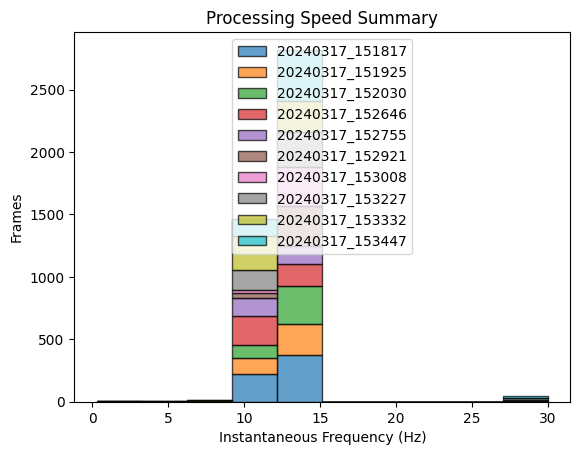

In [35]:
category_data = {}
for category in logs_pdf['date'].unique():
    category_data[category] = logs_pdf[logs_pdf['date'] == category]['t_freq']

# Plot stacked histograms on the same axes
plt.hist(category_data.values(), bins=10, alpha=0.7, edgecolor='black', stacked=True)
plt.legend(category_data.keys(), loc='upper center')
plt.xlabel('Instantaneous Frequency (Hz)')
plt.title('Processing Speed Summary')
plt.ylabel('Frames')


### 3. Frame Accuracy


In [36]:
logs_pdf['date']

143     20240317_151817
144     20240317_151817
145     20240317_151817
146     20240317_151817
147     20240317_151817
             ...       
5493    20240317_153447
5494    20240317_153447
5495    20240317_153447
5496    20240317_153447
5497    20240317_153447
Name: date, Length: 4364, dtype: object

In [ ]:
for date in np.unique(labels_pdf.date):
    plt.plot(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].x, label='Label')
    plt.plot(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].x,  label='MILTracker (Feb4)')
    plt.scatter(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].x)
    plt.scatter(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].x)
    plt.ylabel('X coordinate')
    plt.xlabel('Unix Timestamps')
    plt.title(date)
    plt.legend()
    plt.show()

In [ ]:
for date in np.unique(labels_pdf.date):
    plt.plot(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].y, label='Label')
    plt.plot(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].y,  label='MILTracker (Feb4)')
    plt.scatter(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].y)
    plt.scatter(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].y)
    plt.ylabel('X coordinate')
    plt.xlabel('Unix Timestamps')   
    plt.title(date)
    plt.legend()
    plt.show()

In [38]:
# Measure
labels_int = interp1d(labels_pdf['t'], labels_pdf['x'], kind='linear', fill_value='extrapolate')
logs_pdf['label_x'] = labels_int(logs_pdf['t'])
logs_pdf['abs_diff'] = np.abs(logs_pdf['label_x'] - logs_pdf['x'])
logs_pdf['correct'] = logs_pdf['abs_diff'] < ERR_THRESH

logs_pdf['elapsed_min'] = logs_pdf.groupby('date')['t'].transform(lambda x: x - x.min()) /60 /1000
df1 = logs_pdf.dropna(subset=('x')).groupby('date')['elapsed_min'].max()
df2 = logs_pdf.dropna(subset=('x')).groupby('date')['correct'].mean() * 100
df3 = logs_pdf.dropna(subset=('x')).groupby('date')['abs_diff'].mean()

#plt.plot(logs_pdf['label_x'])
#plt.plot(logs_pdf['x']) 

In [39]:
temp = pd.merge(df1, df2, on='date').reset_index()
plot_df = pd.merge(temp, df3, on='date').reset_index()
change = {
    'date' : 'trial',
    'elapsed_min' : 'duration_minutes',
    'correct' : 'correct_frames_pct',
    'abs_diff' : 'average_pixel_err'
}
plot_df.rename(columns=change, inplace=True)
plot_df['duration_minutes'] = np.round(plot_df['duration_minutes'], 2)
plot_df['correct_frames_pct'] = plot_df['correct_frames_pct'].astype(int)
plot_df['average_pixel_err'] = plot_df['average_pixel_err'].astype(int)
plot_df[['trial', 'duration_minutes', 'correct_frames_pct', 'average_pixel_err']]

,trial,duration_minutes,correct_frames_pct,average_pixel_err
0,20240317_151817,0.79,98,7
1,20240317_151925,0.49,99,6
2,20240317_152030,0.56,95,17
3,20240317_152646,0.59,99,8
4,20240317_152755,0.41,98,10
5,20240317_152921,0.42,100,7
6,20240317_153008,0.41,99,8
7,20240317_153227,0.65,92,28
8,20240317_153332,0.79,99,9
9,20240317_153447,0.70,99,12


In [40]:
plot_df[['trial', 'duration_minutes', 'correct_frames_pct', 'average_pixel_err']].to_csv('testing2.csv')